In [77]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score

In [102]:
df={}
data_master=pd.DataFrame()
for i in range(2,319):
    x='data/data'+str(i)+'.txt'
    df[i]=pd.read_csv(x,sep=',',header=None)
    df[i].drop(columns=[0,4],inplace=True)
    data_master=data_master.append(df[i])

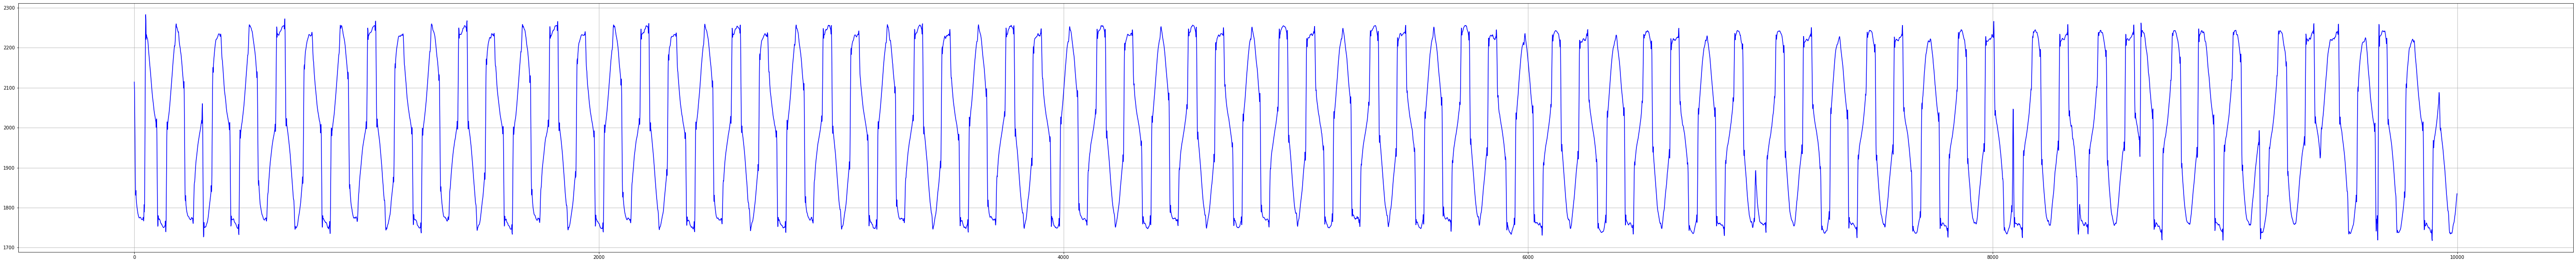

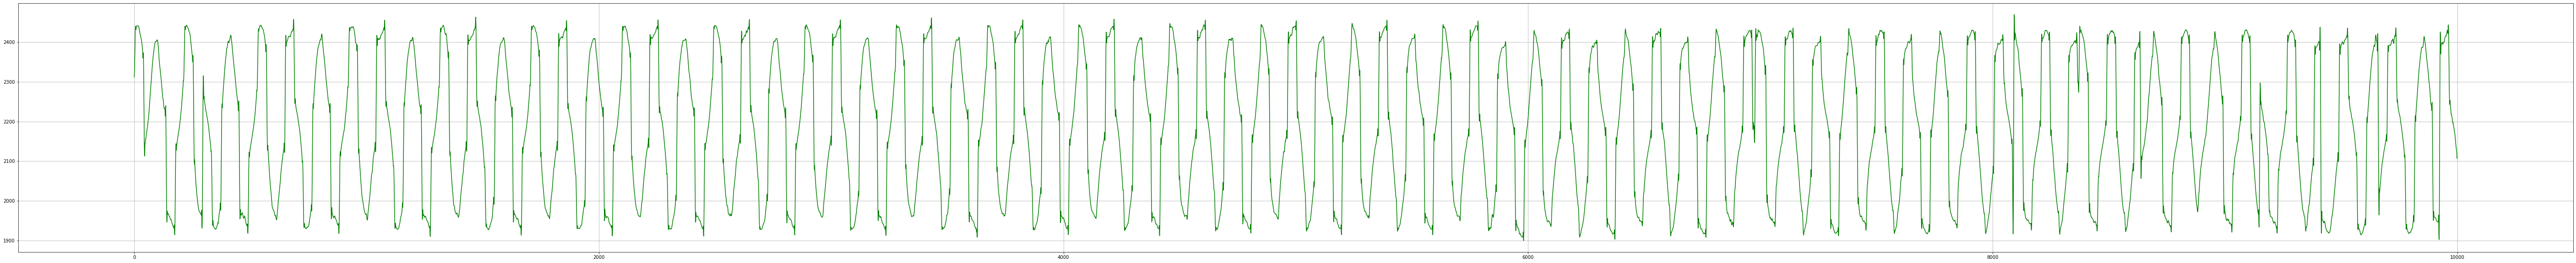

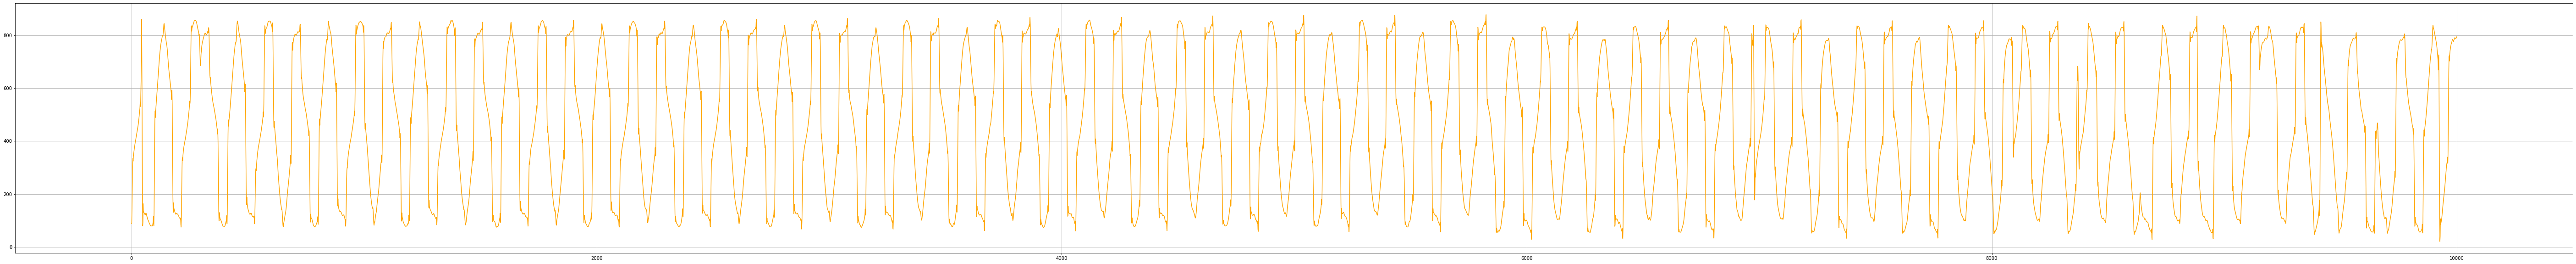

In [108]:
#analysing the waveform with smaller window length inorder to examine the pattern of the waveform.
window_length = 11
poly_order = 4

# Apply the Savitzky-Golay filter
y1 = savgol_filter(df[2][1], window_length, poly_order)
y2 = savgol_filter(df[2][2], window_length, poly_order)
y3 = savgol_filter(df[2][3], window_length, poly_order)

plt.figure(figsize=(100,10))
plt.plot(y1,color='blue')
plt.grid()
plt.show()

plt.figure(figsize=(100,10))
plt.plot(y2,color='green')
plt.grid()
plt.show()

plt.figure(figsize=(100,10))
plt.plot(y3,color='orange')
plt.grid()
plt.show()

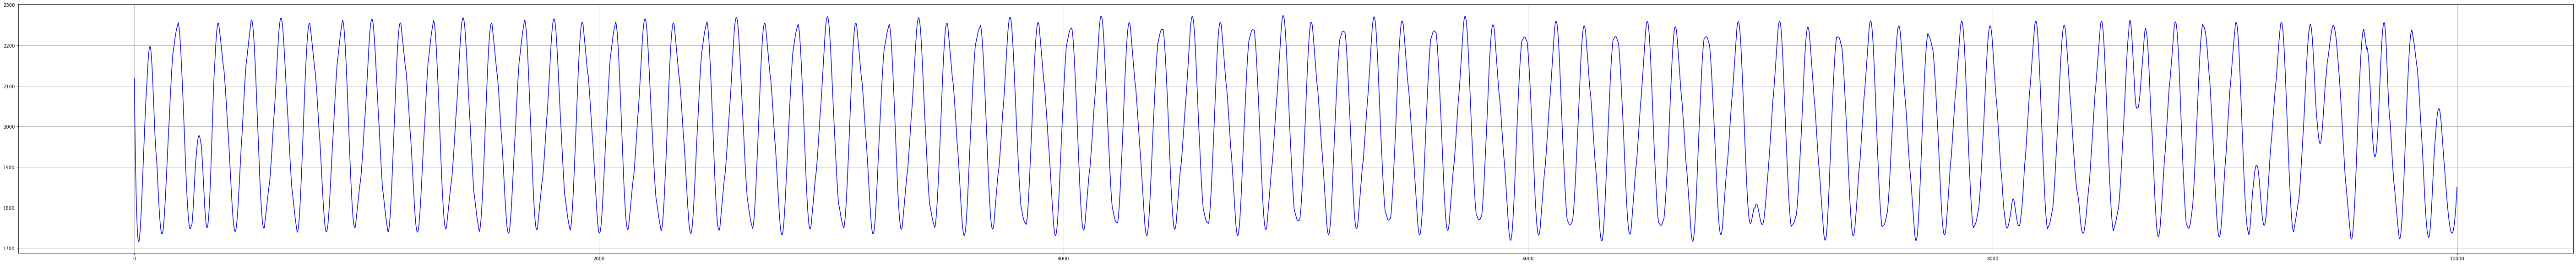

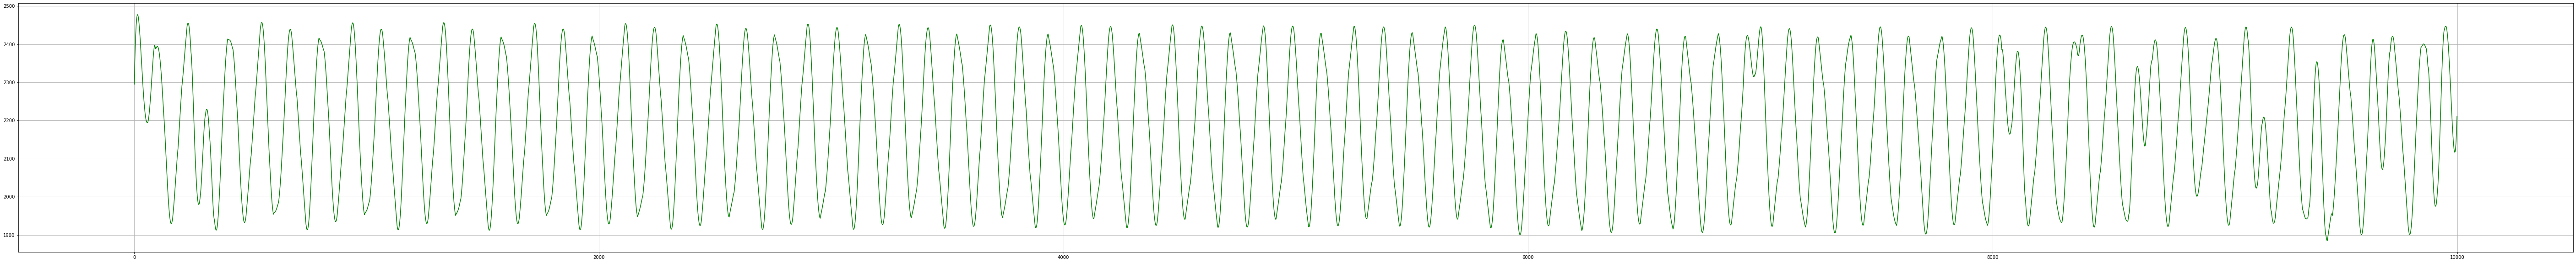

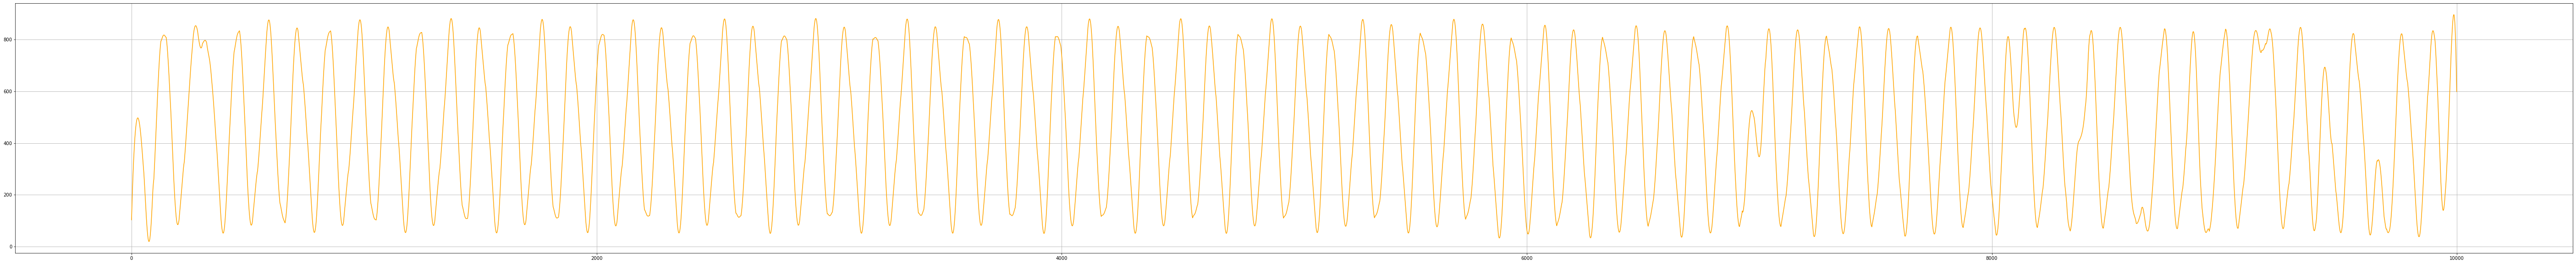

In [109]:
# smoothening the waveform further by increasing the window length in a way that all the patterns are represented by a much simpler waveform
window_length = 101
poly_order = 4

# Apply the Savitzky-Golay filter
y1 = savgol_filter(df[2][1], window_length, poly_order)
y2 = savgol_filter(df[2][2], window_length, poly_order)
y3 = savgol_filter(df[2][3], window_length, poly_order)

plt.figure(figsize=(100,10))
plt.plot(y1,color='blue')
plt.grid()
plt.show()

plt.figure(figsize=(100,10))
plt.plot(y2,color='green')
plt.grid()
plt.show()

plt.figure(figsize=(100,10))
plt.plot(y3,color='orange')
plt.grid()
plt.show()

From the above plot we can see that all the waveforms follow a particular pattern. Hence any changes in between are the sign of an activity. The activity may or may not be a defect.

In [79]:
#function to smoothen the waveform
def smoth(value):
    window_length = 101
    poly_order = 4
    # Apply the Savitzky-Golay filter
    y1 = savgol_filter(value[1], window_length, poly_order)
    y2 = savgol_filter(value[2], window_length, poly_order)
    y3 = savgol_filter(value[3], window_length, poly_order)
    return y1,y2,y3


In [80]:
a,b,c={},{},{} #just like 1,2,3 ==> a,b,c are the three phases for smoothen graph.
for i in range(2,319):
    a[i],b[i],c[i]=smoth(df[i])

In [81]:
#function to find peaks and crests of the smoothened waveform.
def minima_maxima(value):
    peak_indices, _= find_peaks(value)
    minima_indices, _= find_peaks(-value)
    return peak_indices,minima_indices

In [82]:
# from here we have maximas and minimas for all the phases
maxima_a={}
minima_a={}
maxima_b={}
minima_b={}
maxima_c={}
minima_c={}
for i in range(2,319):
    maxima_a[i],minima_a[i]=minima_maxima(a[i])
    maxima_b[i],minima_b[i]=minima_maxima(b[i])
    maxima_c[i],minima_c[i]=minima_maxima(c[i])

In [83]:
#function to calculate the upper limit and lower limit. Anything outside this range will be an outlier or in our case will be a anomaly
def outlier(value):
    q1=np.quantile(value,0.25)
    q3=np.quantile(value,0.75)
    iqr=q3-q1
    ul=q3+(1.5*iqr)
    ll=q1-(1.5*iqr)
    return ul,ll

In [84]:
#To check out of all the datafiles which actually have outliers (Please note: no smoothening is done here. It is for the general or given values)
uplimit={}
lowlimit={}
for i in range(2,319):
    uplimit[i],lowlimit[i]=outlier(a[i])
     #checking outliers for all the files
    if (a[i]>uplimit[i]).any() or (a[i]<lowlimit[i]).any():
        print(i,'.txt file has outliers')

318 .txt file has outliers


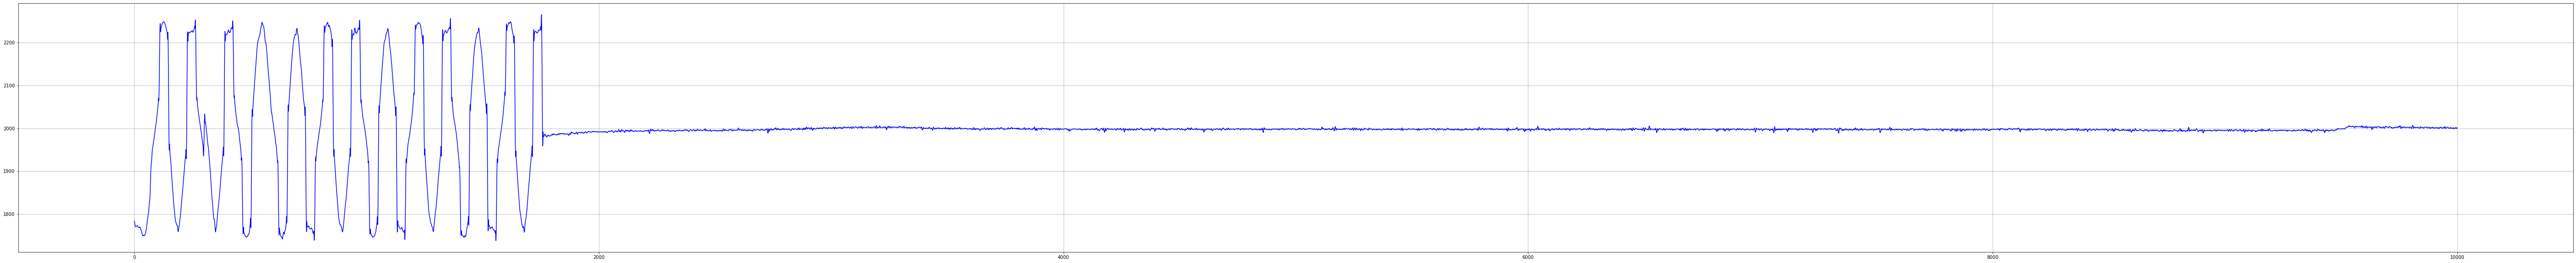

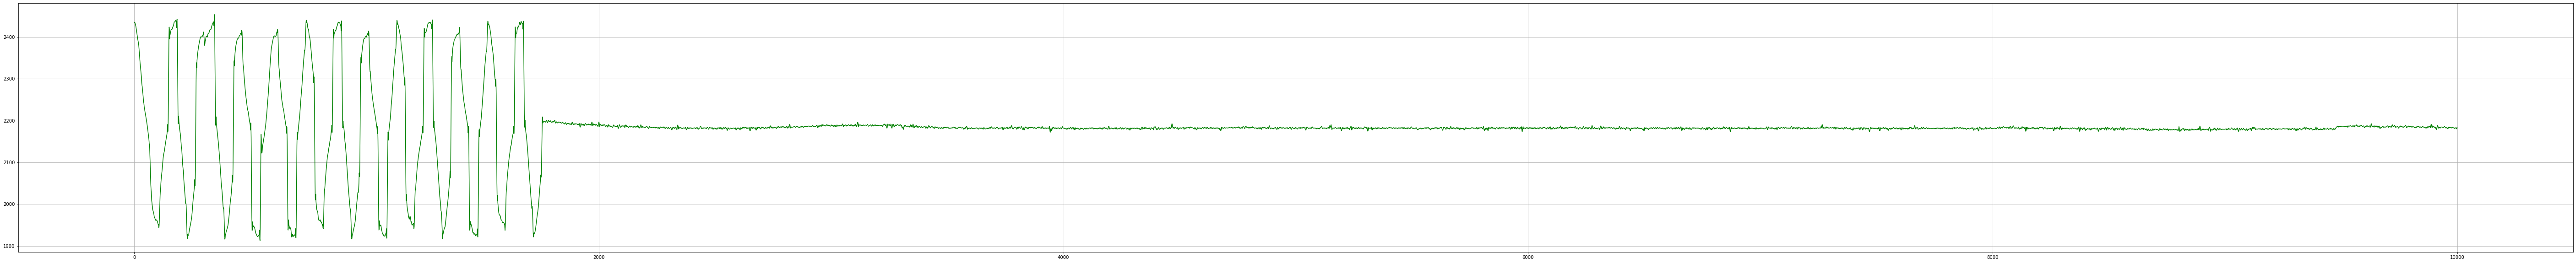

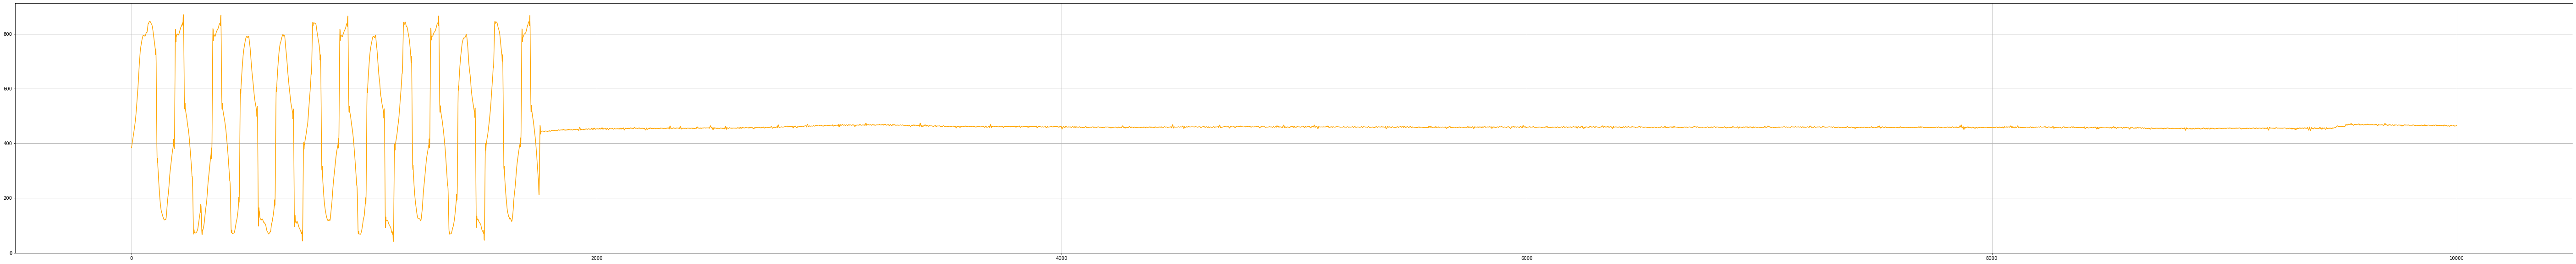

In [110]:
# smoothening the waveform further by increasing the window length in a way that all the patterns are represented by a much simpler waveform
window_length = 11
poly_order = 4

# Apply the Savitzky-Golay filter
y1 = savgol_filter(df[318][1], window_length, poly_order)
y2 = savgol_filter(df[318][2], window_length, poly_order)
y3 = savgol_filter(df[318][3], window_length, poly_order)

plt.figure(figsize=(100,10))
plt.plot(y1,color='blue')
plt.grid()
plt.show()

plt.figure(figsize=(100,10))
plt.plot(y2,color='green')
plt.grid()
plt.show()

plt.figure(figsize=(100,10))
plt.plot(y3,color='orange')
plt.grid()
plt.show()

we can see that the waveform somewhat becomes linear at the end. This may indicate failure or may be another activity.

In [85]:
#The outliers in the smoothened peaks and crests are labeled as defects here.

def phase_defected_peaks(value):
    u_peak,l_peak=outlier(value)
    x=np.zeros(len(value))
    x[np.where(value<l_peak)]=1
    x[np.where(value>u_peak)]=1
    df_peak=pd.DataFrame(data=[value,x]).T
    df_peak.columns=['Phase_Peak','Fault']
    return df_peak


def phase_defected_crests(value):
    
    u_crest,l_crest=outlier(value)
    y=np.zeros(len(value))
    y[np.where(value>u_crest)]=1
    y[np.where(value>u_crest)]=1
    df_crest=pd.DataFrame(data=[value,y]).T
    df_crest.columns=['Phase_Crest','Fault']
    
    return df_crest

In [86]:
#calculating the peaks and crest for all the files and compiling them in a master data frame for each phase and type of peaks.
d_peak_a={}
d_crest_a={}
d_peak_master_a=pd.DataFrame()
d_crest_master_a=pd.DataFrame()
d_peak_b={}
d_crest_b={}
d_peak_master_b=pd.DataFrame()
d_crest_master_b=pd.DataFrame()
d_peak_c={}
d_crest_c={}
d_peak_master_c=pd.DataFrame()
d_crest_master_c=pd.DataFrame()
for i in range(2,319):
    d_peak_a[i]=phase_defected_peaks(a[i][maxima_a[i]])
    d_crest_a[i]=phase_defected_crests(a[i][minima_a[i]])
    d_peak_master_a=d_peak_master_a.append(d_peak_a[i])
    d_crest_master_a=d_crest_master_a.append(d_crest_a[i])
    
    d_peak_b[i]=phase_defected_peaks(b[i][maxima_b[i]])
    d_crest_b[i]=phase_defected_crests(b[i][minima_b[i]])
    d_peak_master_b=d_peak_master_b.append(d_peak_b[i])
    d_crest_master_b=d_crest_master_b.append(d_crest_b[i])
    
    d_peak_c[i]=phase_defected_peaks(c[i][maxima_c[i]])
    d_crest_c[i]=phase_defected_crests(c[i][minima_c[i]])
    d_peak_master_c=d_peak_master_c.append(d_peak_c[i])
    d_crest_master_c=d_crest_master_c.append(d_crest_c[i])

In [88]:
#function to make train data sample and test data sample
def train_test(data):
    train_data = data.sample(frac=0.8, random_state=1)
    test_data = data.drop(train_data.index)
    train_features = train_data.drop('Fault', axis=1)
    train_labels = train_data['Fault']
    test_features = test_data.drop('Fault', axis=1)
    test_labels = test_data['Fault']
    
    return train_features,train_labels,test_features,test_labels

In [89]:
#compiling all the peaks and ccrests for each phase in a master dataframe
d1_a=pd.concat([d_crest_master_a['Phase_Crest'],d_peak_master_a['Phase_Peak']])
d2_a=pd.concat([d_crest_master_a['Fault'],d_peak_master_a['Fault']])

d1_b=pd.concat([d_crest_master_b['Phase_Crest'],d_peak_master_b['Phase_Peak']])
d2_b=pd.concat([d_crest_master_b['Fault'],d_peak_master_b['Fault']])

d1_c=pd.concat([d_crest_master_c['Phase_Crest'],d_peak_master_c['Phase_Peak']])
d2_c=pd.concat([d_crest_master_c['Fault'],d_peak_master_c['Fault']])

master_dataset_a=pd.concat([d1_a,d2_a],axis=1)
master_dataset_b=pd.concat([d1_b,d2_b],axis=1)
master_dataset_c=pd.concat([d1_c,d2_c],axis=1)

In [90]:
# create the Random Forest classifier
rf= RandomForestClassifier(n_estimators=100, random_state=1)

In [91]:
train_features_a,train_labels_a,test_features_a,test_labels_a=train_test(master_dataset_a)
train_features_a,train_labels_a,test_features_a,test_labels_a=train_test(master_dataset_a)
# train the model
rf_a=rf.fit(train_features_a, train_labels_a)
# make predictions on the test set
predictions_a = rf_a.predict(test_features_a)
# evaluate the model performance
print(confusion_matrix(test_labels_a, predictions_a))
print(classification_report(test_labels_a, predictions_a))

[[114   2]
 [  0  18]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       116
         1.0       0.90      1.00      0.95        18

    accuracy                           0.99       134
   macro avg       0.95      0.99      0.97       134
weighted avg       0.99      0.99      0.99       134



The confusion matrix shows that there are 116 instances of the negative class (0) and 18 instances of the positive class (1) in the dataset. The model correctly predicted 114 instances of the negative class and 18 instances of the positive class. There were two instances of the negative class that were incorrectly classified as positive.

The classification report shows that the model has high precision and recall for both classes, with a weighted average F1 score of 0.99. Precision is the ratio of true positives to the total number of predicted positive instances. Recall is the ratio of true positives to the total number of actual positive instances. F1 score is the harmonic mean of precision and recall. The support column indicates the number of instances in each class.

Overall, the model has high accuracy and performs well in predicting both classes, with slightly higher performance for the negative class. However, further analysis of the data and model performance would be necessary to assess the reliability and usefulness of the model for its intended purpose.

In [92]:
train_features_b,train_labels_b,test_features_b,test_labels_b=train_test(master_dataset_b)
train_features_b,train_labels_b,test_features_b,test_labels_b=train_test(master_dataset_b)

rf_b=rf.fit(train_features_b, train_labels_b)

predictions_b = rf_b.predict(test_features_b)

print(confusion_matrix(test_labels_b, predictions_b))
print(classification_report(test_labels_b, predictions_b))

[[88  3]
 [ 0 17]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        91
         1.0       0.85      1.00      0.92        17

    accuracy                           0.97       108
   macro avg       0.93      0.98      0.95       108
weighted avg       0.98      0.97      0.97       108



The confusion matrix shows that there are 91 instances of the negative class (0) and 17 instances of the positive class (1) in the dataset. The model correctly predicted 88 instances of the negative class and 17 instances of the positive class. There were three instances of the negative class that were incorrectly classified as positive.

The classification report shows that the model has high precision and recall for both classes, with a weighted average F1 score of 0.97. Precision is the ratio of true positives to the total number of predicted positive instances. Recall is the ratio of true positives to the total number of actual positive instances. F1 score is the harmonic mean of precision and recall. The support column indicates the number of instances in each class.

Overall, the model has high accuracy and performs well in predicting both classes, with slightly higher performance for the negative class. However, further analysis of the data and model performance would be necessary to assess the reliability and usefulness of the model for its intended purpose.

In [93]:
train_features_c,train_labels_c,test_features_c,test_labels_c=train_test(master_dataset_c)
train_features_c,train_labels_c,test_features_c,test_labels_c=train_test(master_dataset_c)

rf_c=rf.fit(train_features_c, train_labels_c)

predictions_c = rf_c.predict(test_features_c)

print(confusion_matrix(test_labels_c, predictions_c))
print(classification_report(test_labels_c, predictions_c))

[[87  0]
 [ 0 15]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        87
         1.0       1.00      1.00      1.00        15

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



The Random Forest classifier performed very well on the test dataset. The confusion matrix shows that there were 87 true positives and 15 true negatives, and no false positives or false negatives. This means that the classifier correctly predicted all of the samples in the test dataset.

The classification report shows that the precision, recall, and F1-score for both classes (0 and 1) are all 1.00, which indicates perfect classification performance. The overall accuracy is also 1.00, which further confirms that the classifier performed extremely well on this dataset.

### cross-validation to evaluate the performance of the classifier on multiple test sets

In [96]:
scores_a = cross_val_score(rf_a, train_features_a, train_labels_a, cv=5)

In [97]:
scores_b = cross_val_score(rf_b, train_features_b, train_labels_b, cv=5)

In [98]:
scores_c = cross_val_score(rf_c, train_features_c, train_labels_c, cv=5)

In [100]:
scores_a

array([0.91509132, 0.91573214, 0.91957706, 0.91540269, 0.91732536])

Each score in the array represents the performance of the model on a different fold of the data, where the model was trained on the remaining folds. In this case, the array contains five scores, with values ranging from 0.915 to 0.920.

Based on these scores, it seems that the model is performing relatively consistently across the different folds, with scores that are fairly close together. This suggests that the model is not overfitting to the training data and is likely to generalize well to new, unseen data.

In [101]:
scores_b

array([0.91381333, 0.91882667, 0.91913804, 0.92105825, 0.9168978 ])

Each score in the array represents the performance of the model on a different fold of the data, where the model was trained on the remaining folds. In this case, the array contains five scores, with values ranging from 0.914 to 0.921.

Based on these scores, it seems that the model is performing relatively consistently across the different folds, with scores that are fairly close together. This suggests that the model is not overfitting to the training data and is likely to generalize well to new, unseen data.

In [95]:
scores_c

array([0.92459586, 0.91851128, 0.91796875, 0.92285156, 0.92274306])

The output of cross_val_score is an array of scores, where each score corresponds to the performance of the classifier on a different fold of the data. In this case, the output shows that the classifier achieved a score of around 0.92 on each of the 5 folds of the data.

These cross-validation scores can be useful for evaluating the generalization performance of the classifier, as they provide an estimate of how well the classifier is likely to perform on new, unseen data. By performing cross-validation, we can get a more robust estimate of the classifier's performance than we would by simply evaluating it on a single test set.